_Ce notebook a été créé par Yann Vernaz (2017)._

<center>
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_logo.png" style="float:left; max-width: 100px; display: inline" alt="Meetup"/></a> 
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_ML_pau.png" style="float:center; max-width: 250px; display: inline"  alt="Meetup Machine Learning Pau"/></a>
<a href="http://www.helioparc.com" ><img src="img/helioparc_logo.svg" style="float:right; max-width: 200px; display: inline" alt="Technopole Héloparc"/> </a>
</center>
<br>
<hr>
<center><h1>Optimisation distribuée avec Apache Spark</h1></center>
<hr>
<center><h2>Lab 2 - Distribution des algorithmes du Gradient</h2></center>
<hr>

Dans ce _Notebook_ nous implémentons les algorithmes du gradient en version distribuée sur Spark.

## Start Spark

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

# using Spark local mode set to # cores on your machine
conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("Meetup Machine Learning Pau")

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

print("PySpark version:" + str(sc.version))

PySpark version:2.2.0


In [320]:
import numpy as np
np.set_printoptions(precision=8)
from operator import add
import timeit
import utilsLab1
import utilsLab2
from imp import reload
reload(utilsLab1)
reload(utilsLab2)

import matplotlib.pyplot as plt
%matplotlib inline  

## Les données

In [316]:
# read dataset
labelPointRDD = utilsLab2.data_read_undersampling(sc, fileName="retail.csv")
numClass1 = labelPointRDD.map(lambda ex: ex.label==1.0).sum()
numClass2 = labelPointRDD.map(lambda ex: ex.label==-1.0).sum()

# scaled features
data_scaled, numExamples, mean, std = utilsLab2.data_scaled(labelPointRDD)

# trainind dataset (90%) and testing dataset (10%)
weights = [.9, .1]
#seed = 42

trainRDD, testRDD = data_scaled.randomSplit(weights)

numExamplestrain = trainRDD.count()
numClass1train   = trainRDD.map(lambda ex: ex.label==1.0).sum()
numClass2train   = trainRDD.map(lambda ex: ex.label==-1.0).sum()

numExamplestest = testRDD.count()
numClass1test   = testRDD.map(lambda ex: ex.label==1.0).sum()
numClass2test   = testRDD.map(lambda ex: ex.label==-1.0).sum()

print("[Total set]     %d examples (%d in class +1, %d in class -1)." % (numExamples, numClass1, numClass2))
print("[Training set]  %d examples (%d in class +1, %d in class -1)." % (numExamplestrain, numClass1train, numClass2train))
print("[Testing set]   %d examples (%d in class +1, %d in class -1)." % (numExamplestest, numClass1test, numClass2test))

[Total set]     8444 examples (5622 in class +1, 2822 in class -1).
[Training set]  7620 examples (5085 in class +1, 2535 in class -1).
[Testing set]   824 examples (537 in class +1, 287 in class -1).


## Oracles : $J_i(\mathbf{w})$ et $\nabla J_i(\mathbf{w})$

In [43]:
def Ji(example,w):
    """computes the logistic loss for a Labeled point."""
    #x = np.array(example.features)
    x = example.features
    y = example.label
    #return np.log(1. + np.exp(-y*np.dot(x, w)))
    return np.log(1. + np.exp(-y*x.dot(w)))

def gradJi(example,w):
    """computes the gradient for a Labeled point."""
    #x = np.array(example.features)
    x = example.features
    y = example.label
    #return -y*(1./ ( 1. + np.exp(y*np.dot(x, w))))*x
    return (-y/( 1. + np.exp( y*x.dot(w))))*x.toArray()

## Batch Gradient Descent

In [322]:
# Lipschitz upper bound
Lb =  0.25*trainRDD.map(lambda ex: np.linalg.norm(ex.features,2)**2).max()
print("Upper bound on the Lipschitz constant L, Lb=", np.round(Lb,4))

# learning rate
LR = 1.0/Lb
print("Learning rate :", np.round(LR,4))

Upper bound on the Lipschitz constant L, Lb= 0.4025
Learning rate : 2.4847


In [323]:
def batchGD(data, w0=None, learningRate=0.02, momentum=0.0, nesterov=False,
            lambda1=0.0, lambda2=0.0, iterations=100, sampleSize=0, progress=False):
    
    numFeatures = len(data.take(1)[0].features)
    trainSize = data.count()
    v = np.zeros(numFeatures)
    if w0 is None:
        w = np.random.normal(size=numFeatures)
    else:
        w = w0
        
    f = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                  lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)])
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        if nesterov:
            w = w - momentum*v
        
        #wBroadcast = sc.broadcast(wb)
        #gradient = data.map(lambda ex: gradJi(ex,wBroadcast.value)).reduce(add)/trainSize
        gradient = data.map(lambda ex: gradJi(ex,w)).reduce(add)/trainSize + \
                   lambda1*np.sum(np.divide(w, np.sqrt(1. + np.power(w,2)))) + \
                   lambda2*w
        v = momentum*v + learningRate*gradient
        w += -v
        
        fval = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                         lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)]) 
        f = np.vstack((f, fval))
        
        #utilsLab1.show_progress2(k, fval, gradient)
        
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress2(k, fval, gradient)
            
    te = timeit.default_timer()
    
    if (progress==True):
        print("\n*** Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress2(k, fval, gradient)
        
    return w, f.reshape(iterations+1,)

In [335]:
W_INITIAL = np.random.normal(size=12)
ITER_MAX = 1000
print("Initialization, w0 =", W_INITIAL)

Initialization, w0 = [-1.66403096 -0.45011324  0.91539222 -1.54381334  1.01951522  0.48308183
  0.06631704 -0.32415294  0.12403511 -1.22604747 -0.04626501 -1.25618263]


In [336]:
w_GD, f_GD = batchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                     learningRate=LR, 
                     #lambda1=0.01, lambda2=0.005,
                     iterations=ITER_MAX, progress=True)

epoch 1     f(w)=0.7786   Grad_f(w)=0.508107
epoch 101   f(w)=0.6277   Grad_f(w)=0.005125
epoch 201   f(w)=0.6212   Grad_f(w)=0.005055
epoch 301   f(w)=0.6150   Grad_f(w)=0.004986
epoch 401   f(w)=0.6089   Grad_f(w)=0.004917
epoch 501   f(w)=0.6030   Grad_f(w)=0.004851
epoch 601   f(w)=0.5972   Grad_f(w)=0.004785
epoch 701   f(w)=0.5916   Grad_f(w)=0.004720
epoch 801   f(w)=0.5861   Grad_f(w)=0.004657
epoch 901   f(w)=0.5808   Grad_f(w)=0.004594

*** Gradient Descent *** ( 102.77 seconds)
epoch 1000  f(w)=0.5757   Grad_f(w)=0.004534


In [337]:
w_GD_Momentum, f_GD_Momentum = batchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                                       learningRate=LR, momentum=0.9, nesterov=True,
                                       #lambda1=0.01, lambda2=0.005,
                                       iterations=ITER_MAX, progress=True)

epoch 1     f(w)=0.7786   Grad_f(w)=0.508107
epoch 101   f(w)=0.5398   Grad_f(w)=0.004245
epoch 201   f(w)=0.4747   Grad_f(w)=0.003299
epoch 301   f(w)=0.4309   Grad_f(w)=0.002780
epoch 401   f(w)=0.3987   Grad_f(w)=0.002429
epoch 501   f(w)=0.3735   Grad_f(w)=0.002176
epoch 601   f(w)=0.3530   Grad_f(w)=0.001985
epoch 701   f(w)=0.3357   Grad_f(w)=0.001835
epoch 801   f(w)=0.3208   Grad_f(w)=0.001713
epoch 901   f(w)=0.3077   Grad_f(w)=0.001611

*** Gradient Descent *** ( 104.16 seconds)
epoch 1000  f(w)=0.2962   Grad_f(w)=0.001524


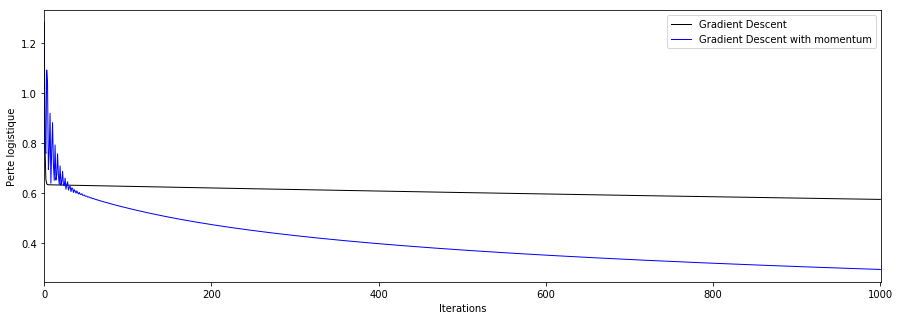

In [338]:
utilsLab1.iteration_plot(2, f=np.array([f_GD, f_GD_Momentum]).T,  
                         label=["Gradient Descent", 
                                "Gradient Descent with momentum"])

## Mini-Batch Gradient Descent

In [328]:
def miniBatchGD(data, w0=None, learningRate=0.02, momentum=0.0, nesterov=False, 
                lambda1=0.0, lambda2=0.0,
                iterations=10, sampleSize=100, progress=False):
    
    numFeatures = len(data.take(1)[0].features)
    trainSize = data.count()
    fraction = float(sampleSize)/float(trainSize)
    v = np.zeros(numFeatures)
    if w0 is None:
        w = np.random.normal(size=numFeatures)
    else:
        w = w0
    
    f = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                  lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)])
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        # choose randomly sampleSize examples (sampling)
        sampleRDD = trainRDD.sample(True, fraction)
        sampleSize = sampleRDD.count()
        
        if nesterov:
            w = w - momentum*v
        
        #wBroadcast = sc.broadcast(w)
        #gradient = sampleRDD.map(lambda ex: gradJi(ex,wBroadcast.value)).reduce(add)/sampleSize
        gradient = sampleRDD.map(lambda ex: gradJi(ex,w)).reduce(add)/sampleSize + \
                    lambda1*np.sum(np.divide(w, np.sqrt(1. + np.power(w,2)))) + \
                    lambda2*w
        v = momentum*v + learningRate*gradient
        w += -v
        
        # for progress trace
        gradient_logistic = data.map(lambda ex: gradJi(ex, w)).reduce(add)/trainSize
        gval = data.map(lambda ex: gradJi(ex, w)).reduce(add)/trainSize + \
                lambda1*np.sum(np.divide(w, np.sqrt(1. + np.power(w,2)))) + \
                lambda2*w
        fval = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                         lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)]) 
        f = np.vstack((f, fval))
        
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress2(k, fval, gval)
    
    te =  timeit.default_timer()  
    
    if (progress==True):
        print("\n*** Mini-Batch Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress2(k, fval, gval)
        
    return w,f.reshape(iterations+1,)

In [339]:
w_miniGD, f_miniGD = miniBatchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                                 learningRate=LR, 
                                 #lambda1=0.01, lambda2=0.005,
                                 iterations=ITER_MAX, sampleSize=1000, progress=True)

epoch 1     f(w)=0.7753   Grad_f(w)=0.263396
epoch 101   f(w)=0.6277   Grad_f(w)=0.006123
epoch 201   f(w)=0.6213   Grad_f(w)=0.006754
epoch 301   f(w)=0.6151   Grad_f(w)=0.007133
epoch 401   f(w)=0.6100   Grad_f(w)=0.022020
epoch 501   f(w)=0.6033   Grad_f(w)=0.011561
epoch 601   f(w)=0.5973   Grad_f(w)=0.005331
epoch 701   f(w)=0.5917   Grad_f(w)=0.005629
epoch 801   f(w)=0.5862   Grad_f(w)=0.004661
epoch 901   f(w)=0.5809   Grad_f(w)=0.007940

*** Mini-Batch Gradient Descent *** ( 228.53 seconds)
epoch 1000  f(w)=0.5760   Grad_f(w)=0.012555


In [340]:
w_miniGD_m, f_miniGD_m = miniBatchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                                     learningRate=LR, momentum=0.9, nesterov=True,
                                     #lambda1=0.01, lambda2=0.005,
                                     iterations=ITER_MAX, sampleSize=1000, progress=True)

epoch 1     f(w)=0.7843   Grad_f(w)=0.271488
epoch 101   f(w)=0.5399   Grad_f(w)=0.006193
epoch 201   f(w)=0.4940   Grad_f(w)=0.084378
epoch 301   f(w)=0.4323   Grad_f(w)=0.023582
epoch 401   f(w)=0.3989   Grad_f(w)=0.011175
epoch 501   f(w)=0.3734   Grad_f(w)=0.003801
epoch 601   f(w)=0.3559   Grad_f(w)=0.033463
epoch 701   f(w)=0.3369   Grad_f(w)=0.021499
epoch 801   f(w)=0.3211   Grad_f(w)=0.012154
epoch 901   f(w)=0.3075   Grad_f(w)=0.003381

*** Mini-Batch Gradient Descent *** ( 225.27 seconds)
epoch 1000  f(w)=0.2964   Grad_f(w)=0.011373


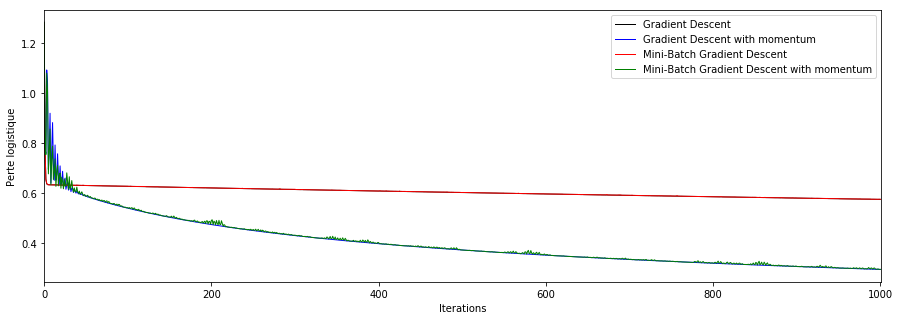

In [341]:
utilsLab1.iteration_plot(4, f=np.array([f_GD, f_GD_Momentum, f_miniGD, f_miniGD_m]).T,  
                         label=["Gradient Descent", 
                                "Gradient Descent with momentum", 
                                "Mini-Batch Gradient Descent",
                                "Mini-Batch Gradient Descent with momentum"])

In [342]:
wopt = w_miniGD_m
prediction = testRDD.map(lambda ex: (ex.label == utilsLab1.prediction(ex.features,wopt))).collect()   
print("Prediction accuracy:", np.round(100.*sum(prediction)/len(prediction),2), "%")

Prediction accuracy: 92.35 %


Confusion matrix, without normalization
[[228  59]
 [  4 533]]


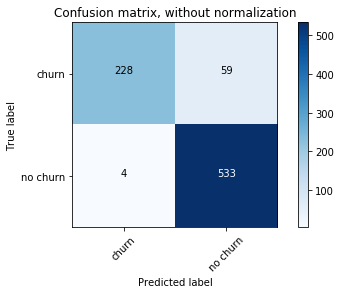

In [343]:
from sklearn.metrics import confusion_matrix

y_test = np.array(testRDD.map(lambda ex: ex.label).collect())
y_pred = np.array(testRDD.map(lambda ex: utilsLab1.prediction(ex.features,wopt,threshold=0.5)).collect())
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
class_names = ["churn", "no churn"]
plt.figure()
utilsLab1.plot_confusion_matrix(cnf_matrix, classes=class_names,
                                title='Confusion matrix, without normalization')

plt.show()

In [344]:
# stop Spark
sc.stop()

# Références

[1] HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent. Feng Niu, Benjamin Recht, Christopher Re, Stephen J. Wright - http://arxiv.org/abs/1106.5730

[2] [Downpour SGD](http://static.googleusercontent.com/media/research.google.com/en//archive/large_deep_networks_nips2012.pdf) - Jeffrey Dean, Greg S. Corrado, Rajat Monga, Kai Chen, Matthieu Devin, Quoc V. Le, Mark Z. Mao, Marc Aurelio Ranzato, Andrew Senior, Paul Tucker, Ke Yang, and Andrew Y. Ng. Large Scale Distributed Deep Networks. NIPS 2012: Neural Information Processing Systems, pages 1–11, 2012.